<a href="https://colab.research.google.com/github/junaidhashmi1/Image_Classification_Code_Repo_Project/blob/main/Breast_Cancer_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [ ]:
# Importing essential libraries for data handling, numerical operations, and machine learning
import os  # For operating system-related tasks like file path manipulation
import numpy as np  # For numerical computations and handling arrays
import pandas as pd  # For handling and processing structured data
# Importing TensorFlow for building and training machine learning models
import tensorflow as tf
# Importing evaluation metrics from sklearn
from sklearn.metrics import *  # For evaluating model performance
# Importing visualization libraries
import matplotlib.pyplot as plt  # For creating visualizations like plots
import seaborn as sns  # For creating aesthetically pleasing statistical plots
# Importing image preprocessing and model-building modules from TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For augmenting and processing images
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models  # For defining neural network architecture
from tensorflow.keras.regularizers import l2  # For kernel regularization
# Setting TensorFlow's data pipeline optimization parameter
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Reading a CSV file that contains dataset information (e.g., image paths and labels)
data_set = pd.read_csv('/content/drive/MyDrive/Dataset/Folds.csv')
# Defining the folder path where images are stored
image_fol = '/content/drive/MyDrive/Dataset/BreaKHis_v1/'
# Defining the class labels for classification tasks
class_names = ['benign', 'malignant']


In [ ]:
# Count occurrences of each unique value
value_counts = data_set['grp'].value_counts()
print(value_counts)

grp
train    25880
test     13665
Name: count, dtype: int64


In [ ]:
# Check for duplicate filenames
duplicate_count = data_set['filename'].duplicated().sum()
print(f'Number of duplicate filenames: {duplicate_count}')

Number of duplicate filenames: 31636


In [ ]:
# Remove duplicates based on the 'filename' column to keep only unique images
data_set = data_set.drop_duplicates(subset='filename', keep='first')

# Display the new shape of the DataFrame
print(f'New shape of the DataFrame: {data_set.shape}')


New shape of the DataFrame: (7909, 4)


# Process Dataset

In [ ]:
# Renaming the column 'filename' to 'path' in the dataset for clarity
data_set = data_set.rename(columns={'filename': 'path'})
# Extracting the label (e.g., 'benign' or 'malignant') from the file path
data_set['label'] = data_set.path.apply(lambda x: x.split('/')[3])
# Assumes the label is stored in the 4th segment of the file path when split by '/'
# Converting the label into an integer representation based on the class_names list
data_set['label_int'] = data_set.label.apply(lambda x: class_names.index(x))
# `benign` will map to 0, and `malignant` will map to 1
# Extracting the file name from the path (last segment of the path after splitting by '/')
data_set['filename'] = data_set.path.apply(lambda x: x.split('/')[-1])
# Updating the 'path' column to include the full path to the image files
data_set['path'] = data_set.path.apply(lambda x: image_fol + x)
# Displaying the first 3 rows of the updated dataset for verification
data_set.head(3)


,fold,mag,grp,path,label,label_int,filename
0,1,100,train,/content/drive/MyDrive/Dataset/BreaKHis_v1/Bre...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,/content/drive/MyDrive/Dataset/BreaKHis_v1/Bre...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,/content/drive/MyDrive/Dataset/BreaKHis_v1/Bre...,benign,0,SOB_B_A-14-22549AB-100-003.png


Count of Benign    :  2480
Count of Malignant :  5429


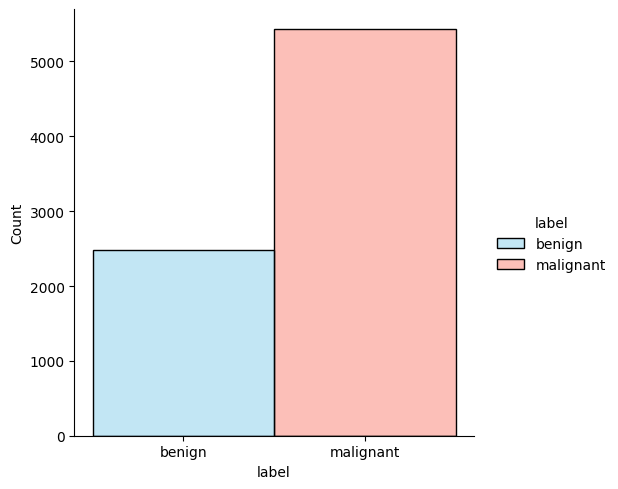

In [ ]:
# Defining colors for benign and malignant
ax = sns.displot(
    data=data_set,
    x='label',
    hue='label',
    palette={'benign': 'skyblue', 'malignant': 'salmon'}
)

# Displaing count of each label
print('Count of Benign    : ', data_set[data_set.label == 'benign'].label.count())
print('Count of Malignant : ', data_set[data_set.label == 'malignant'].label.count())

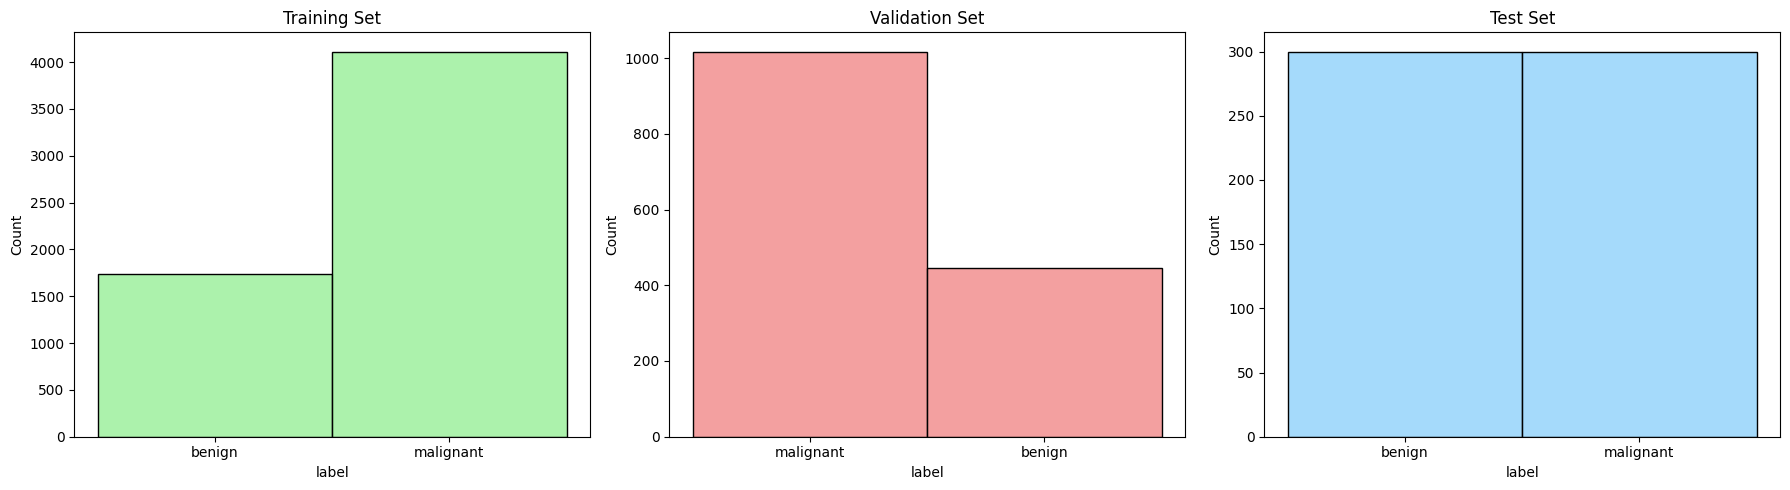

Training set
label
malignant    4112
benign       1735
Name: count, dtype: int64

Validation set
label
malignant    1017
benign        445
Name: count, dtype: int64

Test set
label
benign       300
malignant    300
Name: count, dtype: int64


In [ ]:
test_data = data_set.groupby('label').sample(n=300)
train_data = data_set.drop(test_data.index).reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Split training and validation set
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index).reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

# Assign sets and combine data
test_data['set'] = 'test'
train_data['set'] = 'train'
valid_data['set'] = 'valid'
dataset_combined = pd.concat([train_data, valid_data, test_data])

# Set up the figure with a row of three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot each distribution in a different color and assign to specific axes
sns.histplot(data=train_data, x='label', color='lightgreen', ax=axes[0])
axes[0].set_title('Training Set')

sns.histplot(data=valid_data, x='label', color='lightcoral', ax=axes[1])
axes[1].set_title('Validation Set')

sns.histplot(data=test_data, x='label', color='lightskyblue', ax=axes[2])
axes[2].set_title('Test Set')

# Show the plots in a row
plt.tight_layout()
plt.show()

# Print counts for each set
print('Training set')
print(train_data.label.value_counts())

print('\nValidation set')
print(valid_data.label.value_counts())

print('\nTest set')
print(test_data.label.value_counts())

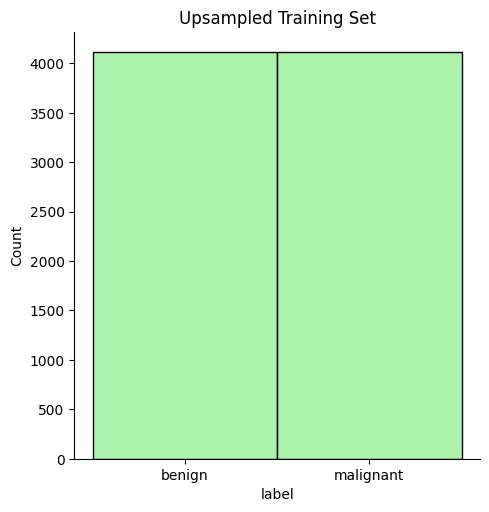

label
benign       4112
malignant    4112
Name: count, dtype: int64


In [ ]:
# Upsample training dataset
max_count = np.max(train_data.label.value_counts())
train_data = train_data.groupby('label').sample(n=max_count, replace=True).reset_index(drop=True)

# Plot distribution after upsampling
ax = sns.displot(data=train_data, x='label', color='lightgreen')
ax.set(title='Upsampled Training Set')
plt.show()

# Display counts to verify upsampling
print(train_data.label.value_counts())

In [ ]:
# Convert label_int to string type for categorical class mode
train_data['label_int'] = train_data['label_int'].astype(str)
valid_data['label_int'] = valid_data['label_int'].astype(str)
# Data augmentation setup
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use a simpler validation generator with rescaling only
valid_datagen = ImageDataGenerator(rescale=1./255)

# Assuming 'train_data' and 'valid_data' are pandas DataFrames containing image paths and labels:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='',
    x_col='path',
    y_col='label_int',
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    directory='',
    x_col='path',
    y_col='label_int',
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse'
)

Found 8224 validated image filenames belonging to 2 classes.
Found 1462 validated image filenames belonging to 2 classes.


In [ ]:

# Create custom CNN model function
def create_custom_cnn(input_shape=(224, 224, 3), num_classes=2):
    model = models.Sequential()

    # Add layers with kernel regularization and batch normalization
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Regularization

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
# Instantiate the model
model = create_custom_cnn(input_shape=(224, 224, 3), num_classes=2)

# Display model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 9,862,466 (37.62 MB)

 Trainable params: 9,860,738 (37.62 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',     # Metric to monitor
        patience=5,            # Number of epochs with no improvement to stop training
        restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored metric
    ),
    ReduceLROnPlateau(
        monitor='val_loss',       # Metric to monitor
        factor=0.1,               # Factor by which to reduce the learning rate
        patience=3,               # Number of epochs with no improvement before reducing
        verbose=1
    )
]

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    verbose=1,
    callbacks=callbacks  # Pass the callbacks to the fit method
)

# Save the trained model
model.save('custom_cnn_model_breast_cancer.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 902s 6s/step - accuracy: 0.7342 - loss: 1.7993 - val_accuracy: 0.6956 - val_loss: 3.7554 - learning_rate: 0.0010
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.8019 - loss: 1.4377 - val_accuracy: 0.6956 - val_loss: 2.4489 - learning_rate: 0.0010
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.8382 - loss: 1.0800 - val_accuracy: 0.6956 - val_loss: 1.5628 - learning_rate: 0.0010
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8638 - loss: 0.8514 - val_accuracy: 0.7073 - val_loss: 2.6185 - learning_rate: 0.0010
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.8658 - loss: 0.7358 - val_accuracy: 0.7025 - val_loss: 3.1304 - learning_rate: 0.0010
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8840 - loss: 0.6186
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
129/129 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.8840 - loss: 0.6185 - val_ac